In [73]:
#!pip install neuralforecast

# **LIBRARY PREPARATION**

In [74]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import MLP, FEDformer
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, MSE, MAE
from neuralforecast.tsdataset import TimeSeriesDataset

from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from scipy.signal import savgol_filter

# **DXG DATA PREPARATION**

In [75]:
# Read Data
df = pd.read_csv('DXG Historical Data 1_6 Fed.csv')

In [76]:
# Add ID constraint
df1 = df
df1['unique_id'] = 'DXG'

# Reorder columns
df1 = df1[['unique_id', 'Date', 'Price']]

# Rename
df1.rename(columns={'Date': 'ds', 'Price': 'y'}, inplace=True)
df1

,unique_id,ds,y
0,DXG,2018-01-02,13401.400
1,DXG,2018-01-03,13371.100
2,DXG,2018-01-04,13522.400
3,DXG,2018-01-05,13159.400
4,DXG,2018-01-06,13363.575
...,...,...,...
2338,DXG,2024-05-28,16800.000
2339,DXG,2024-05-29,16850.000
2340,DXG,2024-05-30,16850.000
2341,DXG,2024-05-31,16800.000


In [77]:
# Change Data Type
df1['ds'] = pd.to_datetime(df1['ds'])
df1['y'] = df1['y'].astype(float)

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2343 entries, 0 to 2342
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   unique_id  2343 non-null   object        
 1   ds         2343 non-null   datetime64[ns]
 2   y          2343 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 55.0+ KB


# **TRAIN-TEST SPLIT**

In [78]:
# Sizing
size = int(len(df1))

# 7 : 3 Ratio
train_data = df1[:int(0.7 *size)]
test_data = df1[int(0.7 * size):]
train_len = len(train_data)
test_len = len(test_data)
print("Training lenght:" , train_len)
print("Test lenght:" , test_len)

Training lenght: 1640
Test lenght: 703


In [79]:
# Train_data MAX Value
train_data.max()

unique_id                    DXG
ds           2022-06-29 00:00:00
y                        46750.0
dtype: object

# **TRAINING PROCESSS**

In [80]:
# Model Configuration
model = FEDformer(
    h=test_len + 90,
    input_size = 100,  # 100 Days of input size
    modes=64,  # Reduced modes for less complexity
    hidden_size=128,  # Increased hidden size
    n_head=8,  # Must be set to 8
    loss=MAE(),
    scaler_type='standard',  # Change the scaler type
    learning_rate=1e-3,  # Fine-tune the learning rate
    max_steps=100,  # Increase the number of training steps
    batch_size=32,  # Adjust batch size
    windows_batch_size=256,  # Adjust window batch size
)

nf = NeuralForecast(
    models=[model],
    freq='D',
)

INFO:lightning_fabric.utilities.seed:Seed set to 1


In [81]:
# Training
nf.fit(df=train_data, static_df=None, verbose=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | decomp        | SeriesDecomp  | 0      | train
4 | enc_embedding | DataEmbedding | 384    | train
5 | dec_embedding | DataEmbedding | 384    | train
6 | encoder       | Encoder       | 251 K  | train
7 | decoder       | Decoder       | 403 K  | train
--------------------------------------------------------
655 K     Trainable params
0         Non-trainable 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.


# **PREDICTION**


In [82]:
forecasts = nf.predict()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:303: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(F.pad(input, self._reversed_padding_repeated_twice, mode=self.padding_mode),
/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [83]:
# Reset Index
train = train_data['y']
test = test_data['y']

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

predict = forecasts['FEDformer']
predict.reset_index(drop=True, inplace=True)

In [84]:
predict_test = predict[0:test_len]
predict_future = predict[test_len:]

In [85]:
# Order predict_future
predict_future_30 = predict_future[:30]
predict_future_60 = predict_future[30:60]
predict_future_90 = predict_future[60:]

In [86]:
# Print Predicted Data
print("\nPredicted Data for the next 30 days:")
print(predict_future_30)

print("\nPredicted Data for the next 60 days:")
print(predict_future_60)

print("\nPredicted Data for the next 90 days:")
print(predict_future_90)


Predicted Data for the next 30 days:
703    33435.398438
704    67908.312500
705    47177.320312
706    63170.882812
707    37646.320312
708    27207.660156
709    48343.718750
710    21811.000000
711    60768.144531
712    24813.662109
713    38193.738281
714    75349.156250
715    71571.414062
716    67718.609375
717    36309.890625
718    40897.867188
719    17450.273438
720    67656.468750
721    72061.984375
722    79198.445312
723    80885.914062
724    65846.320312
725    80869.078125
726    65686.367188
727    70275.312500
728    63822.820312
729    43466.218750
730    37475.222656
731    40536.042969
732    21912.082031
Name: FEDformer, dtype: float32

Predicted Data for the next 60 days:
733    60893.500000
734    44565.351562
735    61803.757812
736    16804.425781
737    70347.687500
738    68431.375000
739    68287.281250
740    40021.640625
741    15144.564453
742    56826.289062
743    76137.765625
744    38121.871094
745    24713.214844
746    56482.679688
747    66076

# **EVALUATION**

In [87]:
mae = mean_absolute_error(test, predict_test)
mape = mean_absolute_percentage_error(test, predict_test)
mse = mean_squared_error(test, predict_test)
rmse = np.sqrt(mean_squared_error(test, predict_test))

print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Mean Square Error (MSE):", mse)
print("Root Mean Square Error (RMSE):", rmse)

Mean Absolute Error (MAE): 16522.28312662992
Mean Absolute Percentage Error (MAPE): 1.0692247733519828
Mean Square Error (MSE): 444083478.67740375
Root Mean Square Error (RMSE): 21073.288273959613


# **VISUALIZATION**

In [88]:
# prompt: adding first_value to the last of test
first_value = predict_test.iloc[0]
train_draw = pd.concat([train, pd.Series([first_value])], ignore_index=True)

**Overall Visualization**

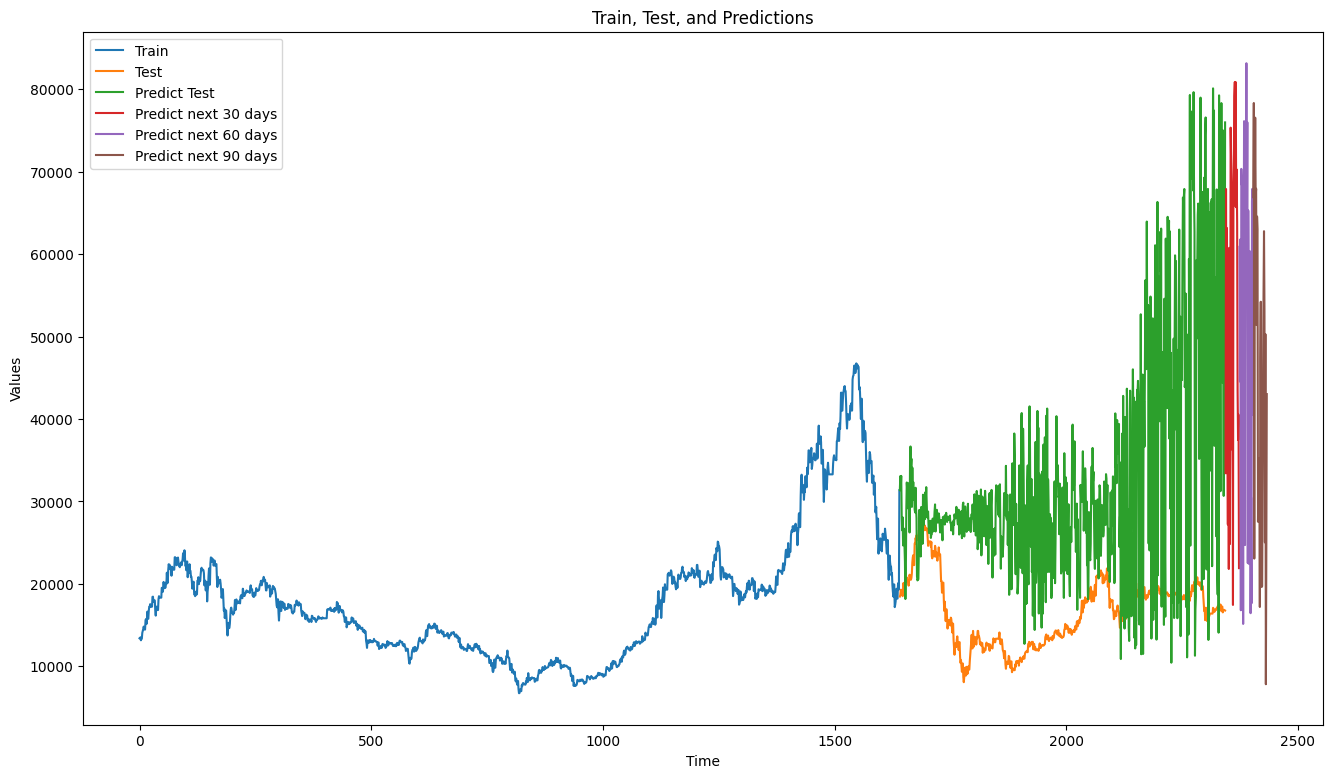

In [89]:
plt.figure(figsize=(16, 9))

train_data_index = pd.RangeIndex(start=0, stop=train_len+1, step=1)
plt.plot(train_draw)
test_data_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(test_data_index, test)

predict_test_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(predict_test_index,(predict_test))

predict_future_30_index = pd.RangeIndex(start=train_len+test_len+1, stop=train_len+test_len+31, step=1)
plt.plot(predict_future_30_index, predict_future_30)
predict_future_60_index = pd.RangeIndex(start=train_len+test_len+31, stop=train_len+test_len+61, step=1)
plt.plot(predict_future_60_index, predict_future_60)
predict_future_90_index = pd.RangeIndex(start=train_len+test_len+61, stop=train_len+test_len+91, step=1)
plt.plot(predict_future_90_index, predict_future_90)

plt.legend(['Train', 'Test', 'Predict Test', 'Predict next 30 days', 'Predict next 60 days', 'Predict next 90 days'])
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Train, Test, and Predictions')
plt.show()

# **---------------------------------------**

# **POLYNOMINAL SMOOTHING**

In [90]:
predict_smoothed = savgol_filter(predict, window_length=31, polyorder=3)

# **RE - PREDICTION**


In [91]:
predict_test = predict_smoothed[0:test_len]
predict_future = predict_smoothed[test_len:]

In [92]:
# Order predict_future
predict_future_30 = predict_future[:30]
predict_future_60 = predict_future[30:60]
predict_future_90 = predict_future[60:]

In [93]:
# Print Predicted Data
print("\nPredicted Data for the next 30 days:")
print(predict_future_30)

print("\nPredicted Data for the next 60 days:")
print(predict_future_60)

print("\nPredicted Data for the next 90 days:")
print(predict_future_90)


Predicted Data for the next 30 days:
[52285.574 51150.066 50541.082 48888.19  47166.66  44703.27  44597.016
 45156.023 46185.41  46342.445 48566.586 51154.54  52297.1   54668.527
 56509.516 57959.81  58163.31  59177.375 61242.227 61395.95  60642.832
 59304.69  60119.887 60141.734 59553.78  56292.65  55197.934 56222.066
 55611.508 54726.418]

Predicted Data for the next 60 days:
[51787.508 50186.168 46487.68  47503.777 46678.406 47235.91  49418.15
 50675.32  51049.496 52986.504 54353.89  55960.98  54234.508 52349.87
 51907.902 49089.477 47851.473 48567.51  48022.992 44923.566 45104.61
 45679.63  47452.74  47365.203 45950.94  47918.03  50397.766 51024.83
 50154.785 51171.844]

Predicted Data for the next 90 days:
[51094.23  51943.094 53189.84  55633.383 55117.7   55731.91  55168.797
 52745.1   49866.293 49384.086 47897.594 45367.066 43644.64  42969.6
 41583.715 40260.754 39027.22  37899.484 36893.94  36026.96  35314.934
 34774.24  34421.258 34272.375 34343.965 34652.418 35214.113 36045.

# **RE - EVALUATION**

In [94]:
mae = mean_absolute_error(test, predict_test)
mape = mean_absolute_percentage_error(test, predict_test)
mse = mean_squared_error(test, predict_test)
rmse = np.sqrt(mean_squared_error(test, predict_test))

print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Mean Square Error (MSE):", mse)
print("Root Mean Square Error (RMSE):", rmse)

Mean Absolute Error (MAE): 16015.616710007705
Mean Absolute Percentage Error (MAPE): 1.042425905075082
Mean Square Error (MSE): 332763820.18360966
Root Mean Square Error (RMSE): 18241.815155943492


# **RE - VISUALIZATION**

In [95]:
# Assuming predict_test is a NumPy array
first_value = pd.Series(predict_test.reshape(-1))  # Convert to pandas Series

# Concatenate train and first_value as Series in a new DataFrame
train_draw = pd.concat([train, first_value], ignore_index=True)

**Overall Visualization**

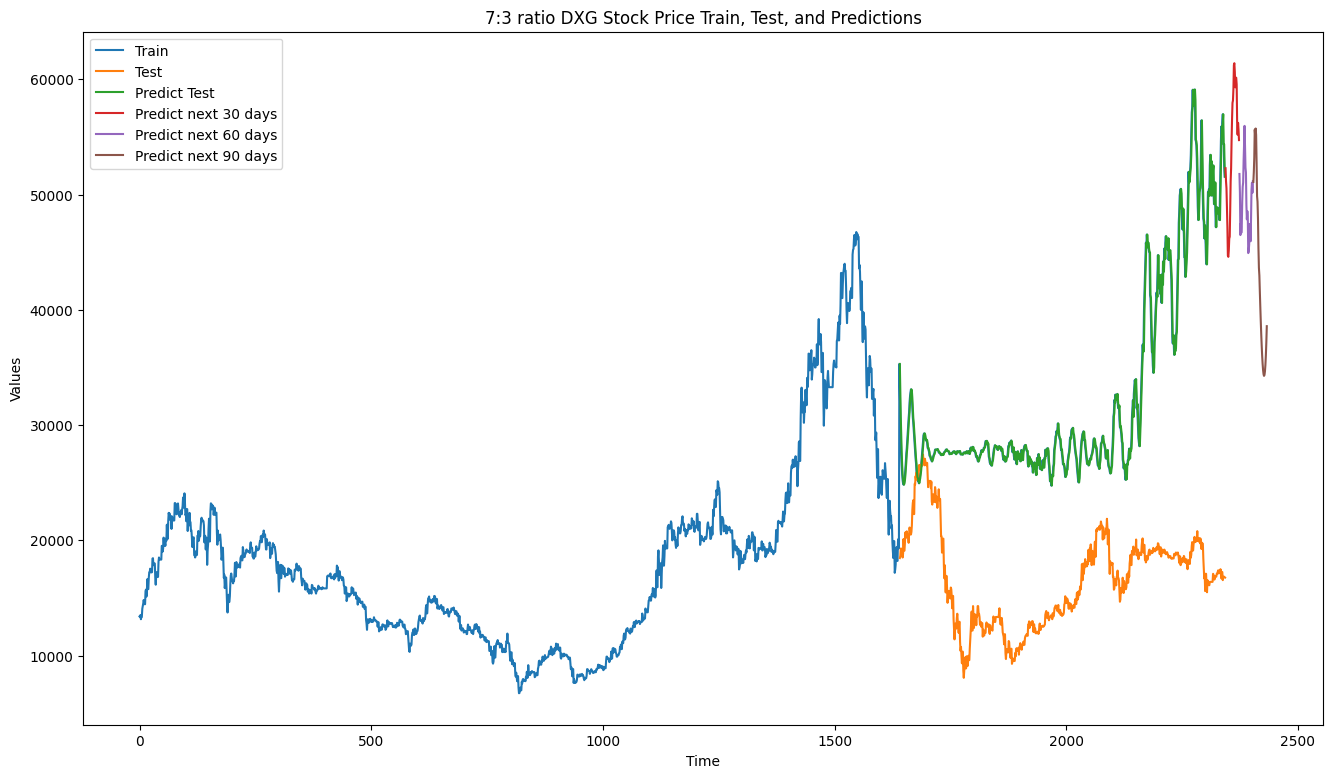

In [96]:
plt.figure(figsize=(16, 9))

train_data_index = pd.RangeIndex(start=0, stop=train_len+1, step=1)
plt.plot(train_draw)
test_data_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(test_data_index, test)

predict_test_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(predict_test_index,(predict_test))

predict_future_30_index = pd.RangeIndex(start=train_len+test_len+1, stop=train_len+test_len+31, step=1)
plt.plot(predict_future_30_index, predict_future_30)
predict_future_60_index = pd.RangeIndex(start=train_len+test_len+31, stop=train_len+test_len+61, step=1)
plt.plot(predict_future_60_index, predict_future_60)
predict_future_90_index = pd.RangeIndex(start=train_len+test_len+61, stop=train_len+test_len+91, step=1)
plt.plot(predict_future_90_index, predict_future_90)

plt.legend(['Train', 'Test', 'Predict Test', 'Predict next 30 days', 'Predict next 60 days', 'Predict next 90 days'])
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('7:3 ratio DXG Stock Price Train, Test, and Predictions')
plt.show()